In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.stats import multivariate_normal as mvnorm
from scipy.stats import uniform, invgamma, bernoulli, poisson, norm
import statsmodels.api as sm
import pandas as pd
from src.preprocessing import prepare_data, prepare_data_no_standardizing, MAR_data_deletion
from src.model_code import Gibbs_MH
from src.create_mnar import create_mnar

#import arviz as az

In [3]:
from statsmodels.tsa.stattools import acf 

#import warnings
#warnings.filterwarnings('ignore')
#warnings.simplefilter('ignore')

In [4]:
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('data/student-mat.csv', sep=";")
features = ["age", "sex", "failures", "higher", "Medu", 
            "absences", "G2", "G3"]
df = df[features]
df.head()

,age,sex,failures,higher,Medu,absences,G2,G3
0,18,F,0,yes,4,6,6,6
1,17,F,0,yes,1,4,5,6
2,15,F,3,yes,1,10,8,10
3,15,F,0,yes,4,2,14,15
4,16,F,0,yes,3,4,10,10


In [6]:
df2 = df.copy()
X_df, y_df2 = prepare_data_no_standardizing(df)

In [7]:
df_missing = create_mnar(df=df2, a0=-0.9, a1=0.01, share_yes=0.2, share_no=0.02)

#df_missing["higher"].value_counts(dropna=False)
#df_missing["G2"].value_counts(dropna=False)


In [8]:

X_df_missing, y_df = prepare_data_no_standardizing(df_missing)
X_df_missing.head()


,age,failures,Medu,absences,G2,sex_M,higher_yes,intercept
0,18,0,4,6,NaN,0,1,1
1,17,0,1,4,NaN,0,1,1
2,15,3,1,10,8.0,0,1,1
3,15,0,4,2,14.0,0,0,1
4,16,0,3,4,10.0,0,1,1


In [9]:
X = X_df_missing
y = y_df.to_numpy()
B = 2000
n = len(y)
thin = 10

In [10]:
#(betas, sigmas2, higher_yes_sim, absences_sim, alphas0, alphas1, gammas0, gammas1,
# accepts_alpha0, accepts_alpha1, accepts_gamma0, accepts_gamma1) = Gibbs_MH(X, y, B, n, higher_yes_col, absences_col, age_col, taus, thin)

In [11]:
(betas, sigmas2, higher_yes_sim, G2_sim, alphas, gammas, etas) = Gibbs_MH(X, y, B, n, thin)

100%|██████████| 39999/39999 [05:58<00:00, 111.67it/s]


In [12]:
betas_df = pd.DataFrame(betas.T, columns=[f"beta_{i}" for i in X_df.columns])
higher_yes_df = pd.DataFrame(higher_yes_sim.T, columns=[f"missing_higher_yes_{i}" for i in range(0, higher_yes_sim.shape[0])])
G2_df = pd.DataFrame(G2_sim.T, columns=[f"missing_G2_{i}" for i in range(0, G2_sim.shape[0])])
alphas_df = pd.DataFrame(alphas.T, columns=[f"alpha_{i}" for i in range(0, alphas.shape[0])])
gammas_df = pd.DataFrame(gammas.T, columns=[f"gamma_{i}" for i in range(0, gammas.shape[0])])
rest_df = pd.DataFrame({"sigmas2": sigmas2.T,
                        "eta2": etas.T})
              

In [13]:
results = pd.concat([betas_df , higher_yes_df, G2_df, alphas_df, gammas_df, rest_df], axis=1) 
results.head()
results.to_csv("results/04_mnar_results.csv")

In [14]:
def MCMC_diagnostics(chain, param):
    plt.subplot(411)
    plt.plot(chain)
    plt.title(f'Trace Plot {param}')

    plt.subplot(412)
    plt.hist(chain, bins=60)
    plt.title(f'Histogram {param}')

    #plt.subplot(413)
    #gw_plot = pm.geweke(chain)
    #plt.scatter(gw_plot[:,0],gw_plot[:,1])
    #plt.axhline(-1.98, c='r')
    #plt.axhline(1.98, c='r')
    
    #plt.ylim(-2.5,2.5)
    #plt.title(f'Geweke Plot Comparing first 10% and Slices of the Last 50% of Chain {param}')

    plt.subplot(414)
    acf_values = acf(chain)
    plt.scatter(range(0, len(acf_values)), acf_values)
    plt.title(f'ACF {param}')
    
    plt.tight_layout()
    plt.show()

/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


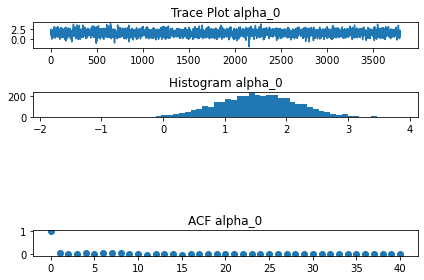

/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


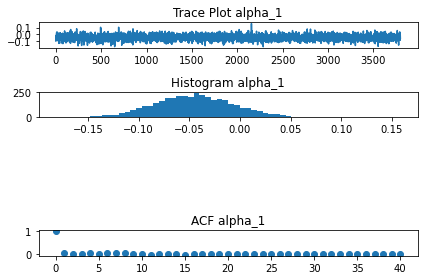

In [15]:
for i, alpha in enumerate(alphas):
    MCMC_diagnostics(alpha, f"alpha_{i}")

/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


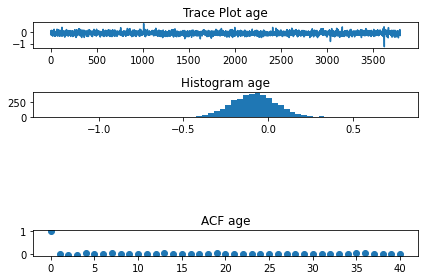

/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


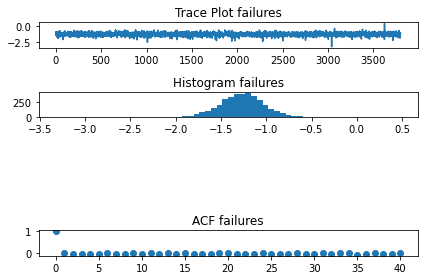

/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


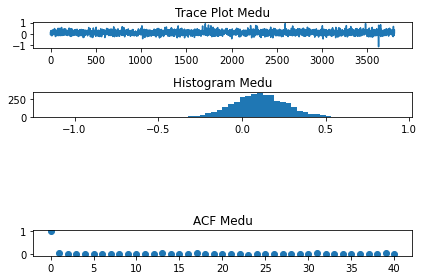

/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


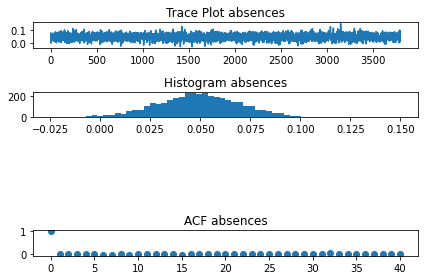

/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


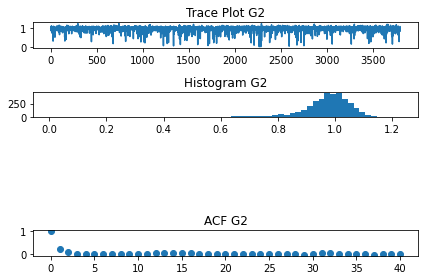

/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


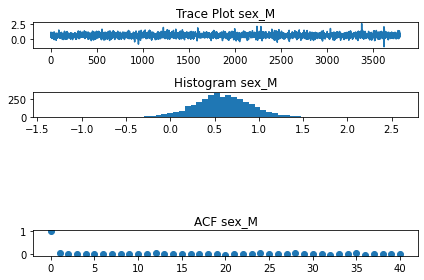

/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


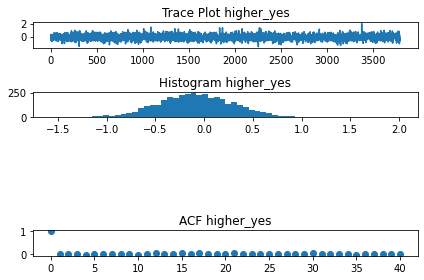

/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


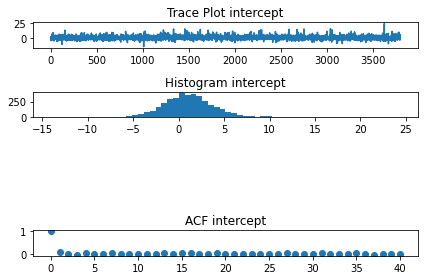

In [16]:
for i, beta in enumerate(betas):
    MCMC_diagnostics(beta, X_df.columns[i])

/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


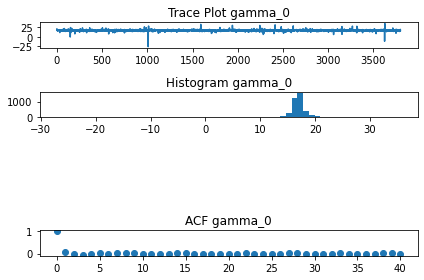

/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


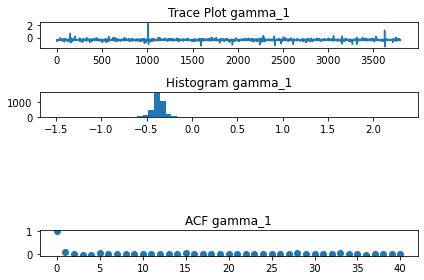

In [17]:
for i, gamma in enumerate(gammas):
    MCMC_diagnostics(gamma, f"gamma_{i}")

/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


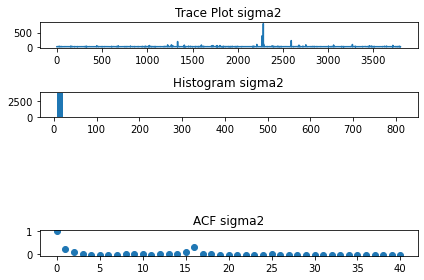

In [18]:
MCMC_diagnostics(sigmas2, "sigma2")

/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


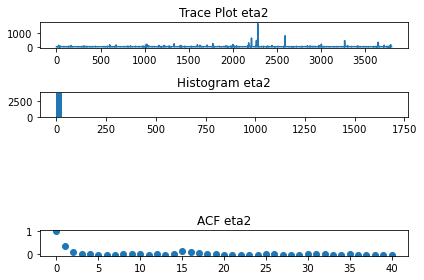

In [19]:
MCMC_diagnostics(etas, "eta2")

/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


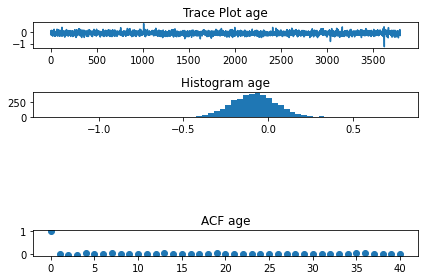

/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


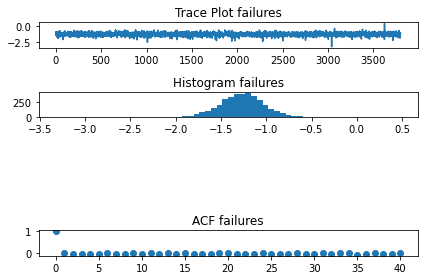

/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


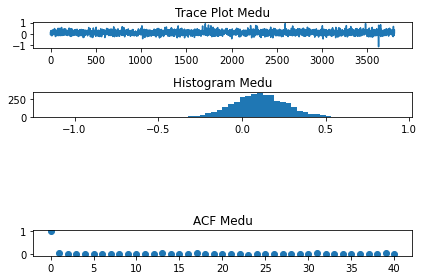

/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


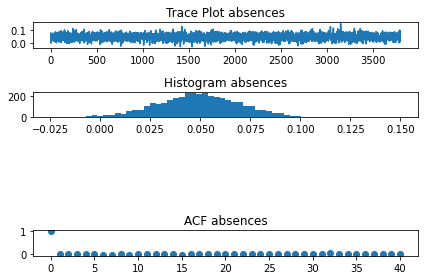

/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


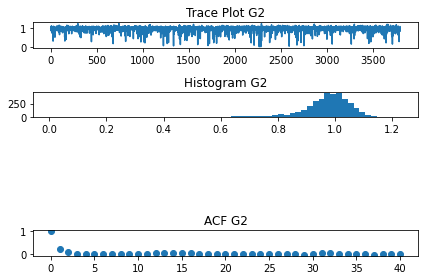

/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


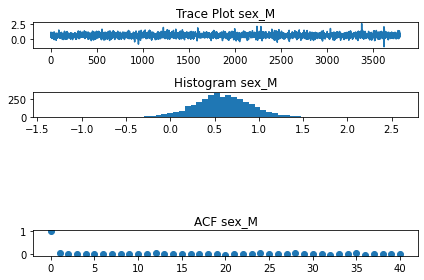

/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


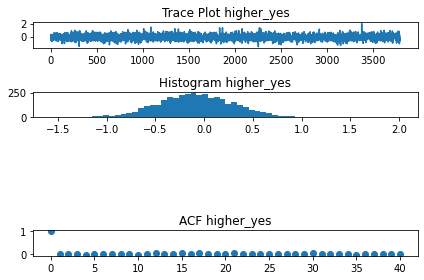

/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/Users/aaronwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


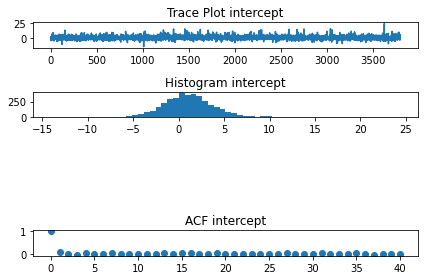

In [20]:
for i, beta in enumerate(betas):
    MCMC_diagnostics(beta, X_df.columns[i])

In [21]:
"""
# thin
betas_thin = betas[:, ::thin]
higher_yes_sim_thin = higher_yes_sim[:, ::thin]
absences_sim_thin = absences_sim[:, ::thin]
alphas0_thin = alphas0[::thin]
alphas1_thin = alphas1[::thin]
gammas0_thin = gammas0[::thin]
gammas1_thin = gammas1[::thin]
sigmas2_thin = sigmas2[::thin]
"""

'\n# thin\nbetas_thin = betas[:, ::thin]\nhigher_yes_sim_thin = higher_yes_sim[:, ::thin]\nabsences_sim_thin = absences_sim[:, ::thin]\nalphas0_thin = alphas0[::thin]\nalphas1_thin = alphas1[::thin]\ngammas0_thin = gammas0[::thin]\ngammas1_thin = gammas1[::thin]\nsigmas2_thin = sigmas2[::thin]\n'

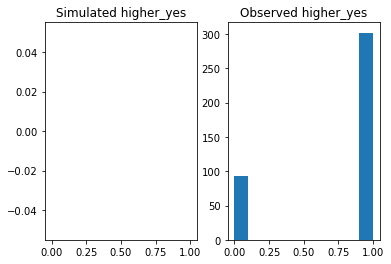

In [22]:
plt.subplot(121)
plt.hist(higher_yes_sim.flatten())
plt.title(f'Simulated higher_yes')


plt.subplot(122)
plt.hist(X.loc[:, "higher_yes"])
plt.title(f'Observed higher_yes')

plt.show()

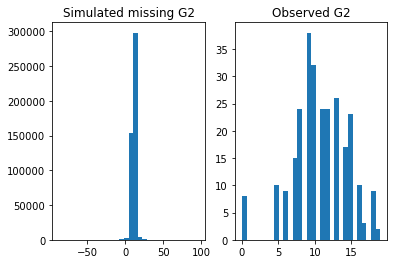

In [23]:
plt.subplot(121)
plt.hist(G2_sim.flatten(), bins=30)
plt.title(f'Simulated missing G2')

plt.subplot(122)
plt.hist(X.loc[:, "G2"], bins=30)
plt.title(f'Observed G2')
plt.show()


In [26]:
for prop in [0.05, 0.1]:
    new_features = create_mnar(df=df2, a0=-0.9, a1=0.01, share_yes=prop, share_no=prop/10)
    new_target = target[new_features.index].copy()
    #betas, sigmas = Gibbs_regression(new_features, new_target, B=20000)
    betas, sigmas2, higher_yes_sim, G2_sim, alphas, gammas, etas = Gibbs_MH(X, y, B, n, thin)
    results = pd.DataFrame(betas.T, columns = features.columns)
    results.to_csv(f'results/04_dists_{prop}.csv', index=False)

NameError: name 'target' is not defined